In [1]:
!pip show -q skin-tone-classifier

In [2]:
import pickle
! pip install skin-tone-classifier --upgrade
!pip install colorgram.py
from IPython.display import Image
import stone
from google.colab.patches import cv2_imshow
from json import dumps # Optional
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from skimage import io, color

import colorgram
import numpy as np

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 118.7/118.7 kB 5.6 MB/s eta 0:00:00
  Created wheel for colormath: filename=colormath-3.0.0-py3-none-any.whl size=39405 sha256=bd5a65066094b9cc902fb555b96d27c2962c011e676f9d7a34ff10ccf8b286aa
  Stored in directory: /root/.cache/pip/wheels/f5/ce/f7/7039d7b57e1a27fc2f6bb2b2abed1be362eefece03caf2fb9a
Successfully built colormath


In [3]:
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from skimage import io, color
import colorgram
from google.colab import files
from google.colab.patches import cv2_imshow
from IPython.display import display, HTML


In [4]:
SKIN_TONE_RANGES = {
    "Type I": {"name": "Porcelain", "range": (240, 220, 190)},
    "Type II": {"name": "Fair", "range": (230, 200, 170)},
    "Type III": {"name": "Medium", "range": (210, 180, 140)},
    "Type IV": {"name": "Olive", "range": (190, 160, 120)},
    "Type V": {"name": "Tan", "range": (170, 140, 100)},
    "Type VI": {"name": "Deep", "range": (150, 120, 80)}
}

In [5]:
def load_image(uploaded_files):
    """Handles image upload and preprocessing"""
    try:
        for fn in uploaded_files.keys():
            image = cv2.imread(fn)
            if image is None:
                raise FileNotFoundError(f"Could not load image: {fn}")
            return cv2.cvtColor(image, cv2.COLOR_BGR2RGB), fn
    except Exception as e:
        print(f"Error loading image: {str(e)}")
        return None, None


In [11]:

def classify_skin_tone(rgb_values):
    """Classifies skin tone using LAB color space"""
    lab = color.rgb2lab(np.array(rgb_values).reshape(1, 1, 3))
    l, a, b = lab[0][0]

    # Fitzpatrick Scale classification rules
    if l > 65: return "Type I"
    elif 60 < l <= 65: return "Type II"
    elif 55 < l <= 60: return "Type III"
    elif 50 < l <= 55: return "Type IV"
    elif 45 < l <= 50: return "Type V"
    else: return "Type VI"

In [6]:
def get_color_palette(image_path, num_colors=6):
    """Extracts color palette from image"""
    colors = colorgram.extract(image_path, num_colors)
    return [(color.rgb.r, color.rgb.g, color.rgb.b) for color in colors]

In [7]:
from skimage import color as skcolor
def analyze_color_tone(palette):
    """Analyzes overall color tone using extracted palette"""
    avg_hue = np.mean([skcolor.rgb2hsv(np.array(c).reshape(1, 1, 3) / 255)[0][0][0] for c in palette])  # Use skcolor.rgb2hsv
    return "Warm" if 0.05 < avg_hue < 0.6 else "Cool"

In [8]:
def generate_recommendations(skin_type, color_tone):
    """Generates personalized color recommendations"""
    base_colors = {
        "Type I": ["#FFF0F5", "#F0FFFF", "#FAF0E6", "#E6E6FA", "#FFFAF0"],
        "Type II": ["#FFB6C1", "#87CEFA", "#98FB98", "#DDA0DD", "#FFDAB9"],
        "Type III": ["#CD853F", "#6B8E23", "#4682B4", "#D2691E", "#808000"],
        "Type IV": ["#8B4513", "#2E8B57", "#4169E1", "#A0522D", "#556B2F"],
        "Type V": ["#A52A2A", "#006400", "#00008B", "#8B008B", "#4B0082"],
        "Type VI": ["#FF1493", "#00BFFF", "#32CD32", "#FFD700", "#8A2BE2"]
    }
    tone_modifiers = {
        "Warm": ["#FF4500", "#FFD700", "#CD853F", "#8B0000", "#FF6347"],
        "Cool": ["#4169E1", "#9370DB", "#48D1CC", "#6A5ACD", "#87CEEB"]
    }

    return base_colors[skin_type][:3] + tone_modifiers[color_tone][:3]

In [9]:
def display_color_palette(colors, title):
    """Displays a color palette with hex codes"""
    fig, ax = plt.subplots(figsize=(10, 2))
    ax.set_title(title, fontsize=14)
    ax.set_xticks([])
    ax.set_yticks([])

    for i, color in enumerate(colors):
        # Corrected line: Pass x, y, width, height separately
        rect = patches.Rectangle((i/len(colors), 0), 1/len(colors), 1, color=np.array(color)/255)
        ax.add_patch(rect)
        hex_color = '#%02x%02x%02x' % tuple(color)
        ax.text((i+0.5)/len(colors), 0.5, hex_color.upper(),
                ha='center', va='center', color='white', fontsize=10)

    plt.show()

Saving mypassportsizephoto.jpg to mypassportsizephoto (1).jpg


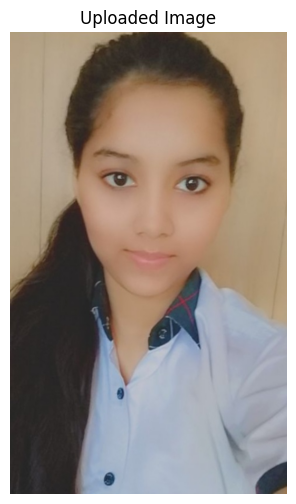

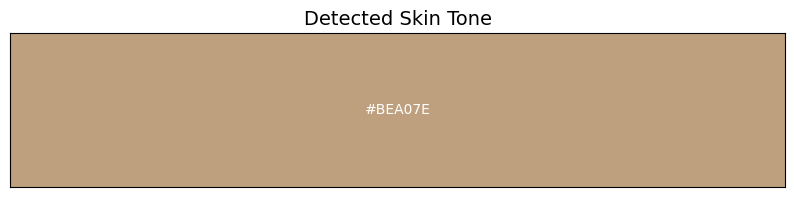

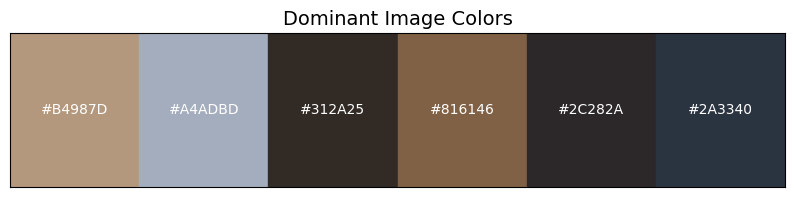

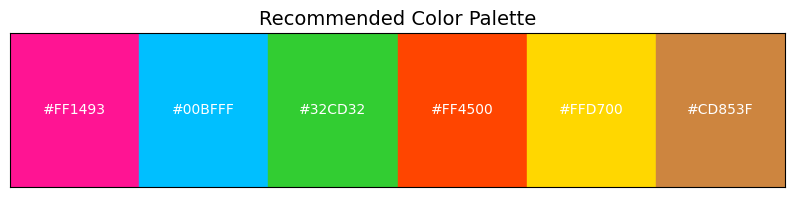

In [12]:
def main():
    # Image Upload
    uploaded = files.upload()
    img, path = load_image(uploaded)

    if img is None:
        print("Failed to process image")
        return
    # Display uploaded image
    plt.figure(figsize=(8, 6))
    plt.imshow(img)
    plt.title("Uploaded Image", fontsize=12)
    plt.axis('off')
    plt.show()

    # Skin Tone Analysis
    try:
        result = stone.process(path, image_type="color", return_report_image=True)
        skin_tone_hex = result["faces"][0]["skin_tone"]
        rgb_values = tuple(int(skin_tone_hex.lstrip('#')[i:i+2], 16) for i in (0, 2, 4))
        skin_type = classify_skin_tone(rgb_values)
    except Exception as e:
        print(f"Analysis error: {str(e)}")
        return

    # Color Analysis
    palette = get_color_palette(path)
    color_tone = analyze_color_tone(palette)

    # Generate Recommendations
    recommendations = generate_recommendations(skin_type, color_tone)

    # Display Results
    display(HTML(f"""
    <h2 style='color: #2E4053;'>Analysis Results</h2>
    <ul style='font-size: 16px;'>
        <li>Detected Skin Tone: <strong>{SKIN_TONE_RANGES[skin_type]['name']}</strong> ({skin_type})</li>
        <li>Color Palette Tone: <strong>{color_tone}</strong></li>
        <li>Recommended Colors: {', '.join([f'<span style="color:{c};">■</span> {c}' for c in recommendations])}</li>
    </ul>
    """))

    # Visualizations
    display_color_palette([rgb_values], "Detected Skin Tone")
    display_color_palette(palette, "Dominant Image Colors")
    display_color_palette([tuple(int(c.lstrip('#')[i:i+2], 16) for i in (0, 2, 4)) for c in recommendations],"Recommended Color Palette")

if __name__ == "__main__":
    main()